In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask'

In [3]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask'

!kaggle datasets download -d andrewmvd/face-mask-detection

/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask
 95% 377M/398M [00:04<00:00, 50.7MB/s]
100% 398M/398M [00:04<00:00, 95.4MB/s]


In [4]:
!unzip \*.zip && rm *.zip

Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: annotations/maksssk

In [5]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 7.1 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import glob
import yaml
import torch
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path
from sklearn.model_selection import train_test_split

In [7]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.207 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.5/78.2 GB disk)


In [8]:
directory = "/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask"
image_directory = directory + "/images"
annotation_directory = directory + "/annotations"
annotations = list(Path(annotation_directory).glob(r'**/*{}'.format('xml')))

In [9]:
class_id = {
    "with_mask" : 0,
    "mask_weared_incorrect" : 1,
    "without_mask" : 2
}

data_dict = {
    'filename': [],
    'label': [],
    'class_id': [],
    'width': [],
    'height': [],
    'bboxes': []
}
for annotation_path in annotations:
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.findall("object"):
        label = obj.find("name").text

        bbox = []
        bndbox_tree = obj.find('bndbox')
        bbox.append(int(bndbox_tree.find('xmin').text))
        bbox.append(int(bndbox_tree.find('ymin').text))
        bbox.append(int(bndbox_tree.find('xmax').text))
        bbox.append(int(bndbox_tree.find('ymax').text))
        size = root.find('size')

        data_dict['filename'].append(filename)
        data_dict['width'].append(int(size.find('width').text))
        data_dict['height'].append(int(size.find('height').text))
        data_dict['label'].append(label)
        data_dict['class_id'].append(class_id[label])
        data_dict['bboxes'].append(bbox)

df_data = pd.DataFrame(data_dict)

df_data.head()

,filename,label,class_id,width,height,bboxes
0,maksssksksss0.png,without_mask,2,512,366,"[79, 105, 109, 142]"
1,maksssksksss0.png,with_mask,0,512,366,"[185, 100, 226, 144]"
2,maksssksksss0.png,without_mask,2,512,366,"[325, 90, 360, 141]"
3,maksssksksss1.png,with_mask,0,400,156,"[321, 34, 354, 69]"
4,maksssksksss1.png,with_mask,0,400,156,"[224, 38, 261, 73]"


In [10]:
df_data.isna().sum()

filename    0
label       0
class_id    0
width       0
height      0
bboxes      0
dtype: int64

In [11]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4072 non-null   object
 1   label     4072 non-null   object
 2   class_id  4072 non-null   int64 
 3   width     4072 non-null   int64 
 4   height    4072 non-null   int64 
 5   bboxes    4072 non-null   object
dtypes: int64(3), object(3)
memory usage: 191.0+ KB


In [12]:
df_data.label.unique()

array(['without_mask', 'with_mask', 'mask_weared_incorrect'], dtype=object)

In [13]:
print(f"Total 'without_mask' labels: {sum(df_data.label == 'without_mask')}")
print(f"Total 'mask_weared_incorrect' labels: {sum(df_data.label == 'mask_weared_incorrect')}")
print(f"Total 'with_mask' labels: {sum(df_data.label == 'with_mask')}")

Total 'without_mask' labels: 717
Total 'mask_weared_incorrect' labels: 123
Total 'with_mask' labels: 3232


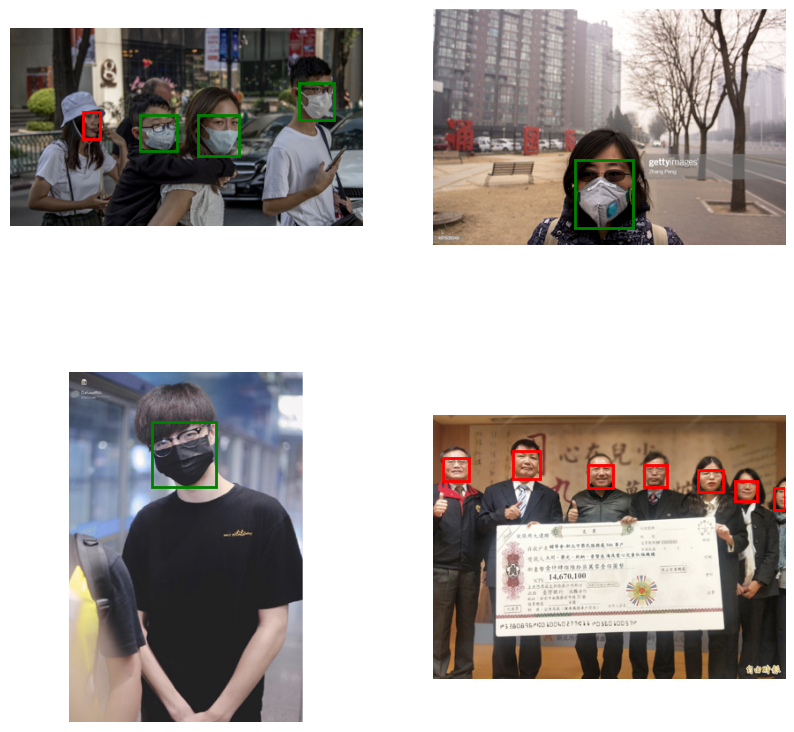

In [14]:
def show_random_images_with_bbox(df):
    all_images = os.listdir(image_directory)
    random_image_filename = random.sample(all_images, 4)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    for i, filename in enumerate(random_image_filename):
        selected_df = df[df['filename'] == filename]

        image = Image.open(image_directory + '/' + filename)

        ax.flat[i].imshow(image)
        ax.flat[i].axis(False)

        image_bboxes = []
        for df_index in range(0, len(selected_df)):
            color = "g"
            if selected_df.iloc[df_index].class_id == 1: color = "y"
            elif selected_df.iloc[df_index].class_id == 2: color = "r"

            x_min, y_min, x_max, y_max = selected_df.iloc[df_index].bboxes

            rect = patches.Rectangle([x_min, y_min], x_max-x_min, y_max-y_min,
                             linewidth=2, edgecolor=color, facecolor="none")
            ax.flat[i].add_patch(rect)

show_random_images_with_bbox(df_data)

In [15]:
def pascal_voc_to_yolo_bbox(bbox_array, w, h):
    x_min, y_min, x_max, y_max = bbox_array

    x_center = ((x_max + x_min) / 2) / w
    y_center = ((y_max + y_min) / 2) / h

    width = (x_max - x_min) / w
    height = (y_max - y_min) / h

    return [x_center, y_center, width, height]

In [16]:
train_path = "/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask/datasets/train"
valid_path = "/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask/datasets/valid"
test_path = "/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask/datasets/test"

os.mkdir("/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask/datasets")
os.mkdir(train_path)
os.mkdir(valid_path)
os.mkdir(test_path)

In [17]:
train, test = train_test_split(df_data.filename.unique(), test_size=0.2, random_state=23)
train, valid = train_test_split(train, test_size=0.15, random_state=23)

def copy_image_file(image_items, folder_name):
    for image in image_items:
            image_path = image_directory + "/" + image
            new_image_path = os.path.join(folder_name, image)
            shutil.copy(image_path, new_image_path)

def create_label_file(image_items, folder_name):
    for image in image_items:
        fileName = Path(image).stem
        df = df_data[df_data['filename'] == image]
        with open(folder_name + "/" + fileName +'.txt', 'w') as f:
            for i in range(0, len(df)):
                bbox = pascal_voc_to_yolo_bbox(df.iloc[i]['bboxes'], df.iloc[i]['width'], df.iloc[i]['height'])
                bbox_text = " ".join(map(str, bbox))
                txt = str(df.iloc[i]['class_id'])+ " " + bbox_text
                f.write(txt)
                if i != len(df) - 1:
                    f.write("\n")


copy_image_file(train, train_path)
copy_image_file(valid, valid_path)
copy_image_file(test, test_path)

create_label_file(train, train_path)
create_label_file(valid, valid_path)
create_label_file(test, test_path)

In [18]:
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"There are {len(dirnames)} directories and {len(glob.glob(filepath + '/*.png', recursive = True))} images in '{dirpath}'.")

walk_through_dir(train_path)
walk_through_dir(valid_path)
walk_through_dir(test_path)

There are 0 directories and 579 images in '/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask/datasets/train'.
There are 0 directories and 103 images in '/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask/datasets/valid'.
There are 0 directories and 171 images in '/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask/datasets/test'.


In [19]:
classes = list(df_data.label.unique())
class_count = len(classes)
facemask_yaml = f"""
    train: train
    val: valid
    test: test
    nc: {class_count}
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    """

with open('facemask.yaml', 'w') as f:
    f.write(facemask_yaml)

%cat facemask.yaml


    train: train
    val: valid
    test: test
    nc: 3
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    

In [20]:
model = YOLO("yolov8n.pt")
model.train(data="facemask.yaml", epochs=50)

100%|██████████| 6.23M/6.23M [00:00<00:00, 91.4MB/s]
Ultralytics YOLOv8.0.207 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=facemask.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=Tru

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e3a396186a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [21]:
model.val(data="facemask.yaml")

Ultralytics YOLOv8.0.207 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask/datasets/valid.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]
                   all        103        579      0.834      0.762      0.819      0.573
             with_mask        103        473      0.907      0.905      0.947      0.665
 mask_weared_incorrect        103         20      0.717       0.55      0.617      0.426
          without_mask        103         86      0.877       0.83      0.893      0.629
Speed: 0.6ms preprocess, 31.4ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e3aa68ab130>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

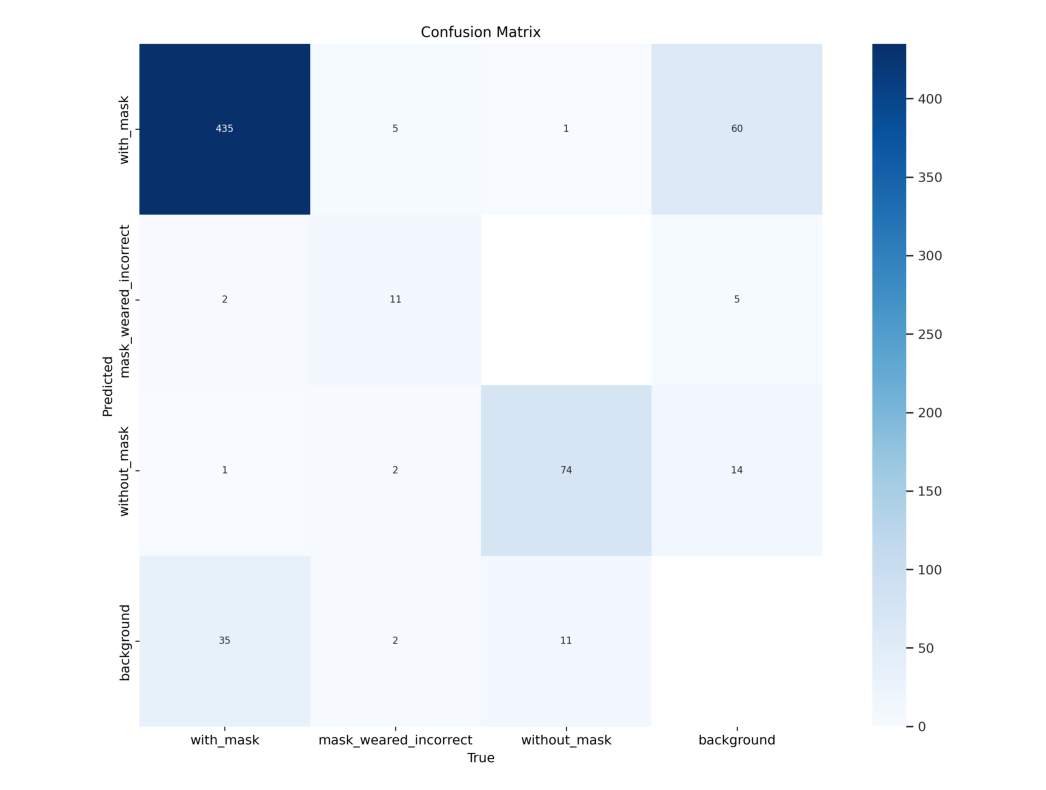

In [23]:
confusion_matrix = Image.open("/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask/runs/detect/train2/confusion_matrix.png")
plt.figure(figsize=(20,10))
plt.imshow(confusion_matrix)
plt.axis(False)
plt.show()

In [24]:
val_label = Image.open("/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask/runs/detect/train2/val_batch0_labels.jpg")
val_pred = Image.open("/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask/runs/detect/train2/val_batch0_pred.jpg")


plt.figure(figsize=(20,10))
plt.imshow(val_label)
plt.title("Label")
plt.axis(False)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(val_pred)
plt.title("Prediction")
plt.axis(False)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [26]:
model = YOLO(model="/content/gdrive/MyDrive/Colab Notebooks/yolov8/FaceMask/runs/detect/train/weights/best.pt")

In [27]:
filenames = glob.glob(test_path+"/*.png", recursive=False)
test_image1 = cv2.imread(filenames[0])
test_image2 = cv2.imread(filenames[1])

results = model.predict([test_image1, test_image2], save=True, line_thickness=1)

WARNING ⚠️ 'line_thickness' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'line_width' instead.

0: 448x640 3 with_masks, 1: 448x640 5 with_masks, 2 without_masks, 211.8ms
Speed: 5.0ms preprocess, 105.9ms inference, 5.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


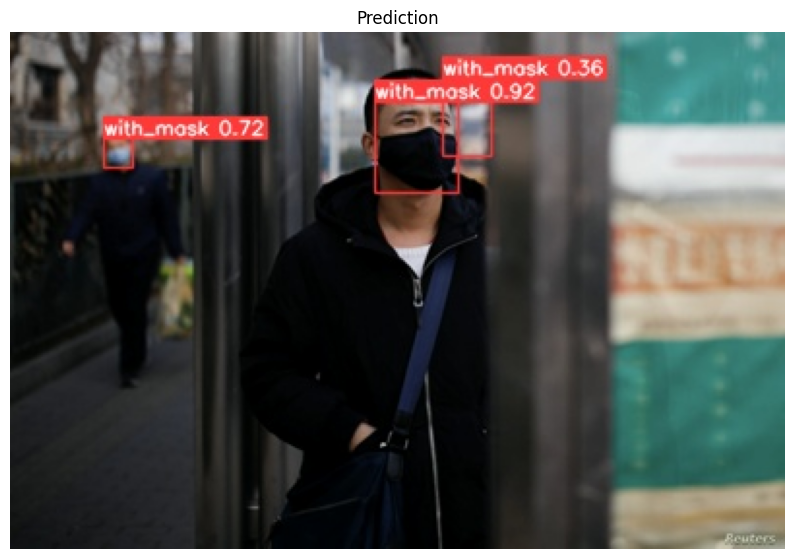

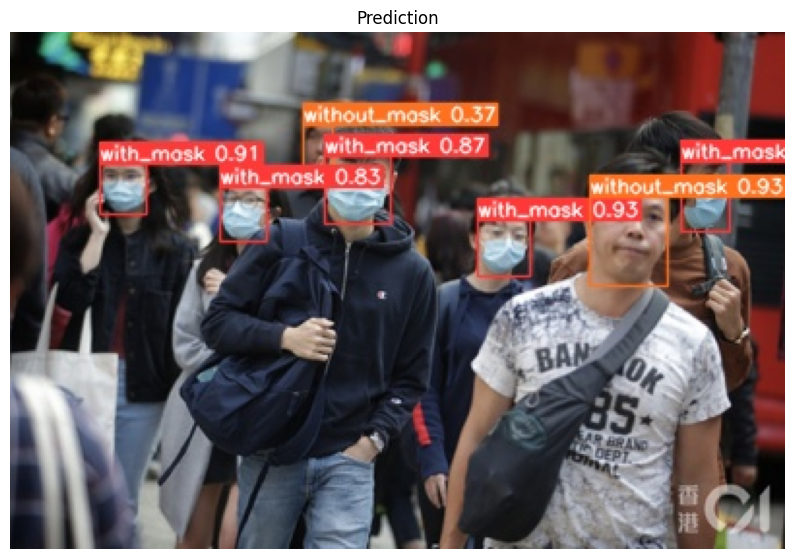

In [28]:
predicted_image = Image.open("runs/detect/predict/image0.jpg")
plt.figure(figsize=(10,10))
plt.imshow(predicted_image)
plt.title("Prediction")
plt.axis(False)
plt.show()

predicted_image = Image.open("runs/detect/predict/image1.jpg")
plt.figure(figsize=(10,10))
plt.imshow(predicted_image)
plt.title("Prediction")
plt.axis(False)
plt.show()